In [ ]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
# sk-1feb7ffcf87f43a2a3feb12cc8349348
_set_env("DEEPSEEK_API_KEY")

# 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
_set_env("TAVILY_API_KEY")


In [20]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [7]:
graph_builder = StateGraph(State)

In [10]:
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': "Introduction to LangGraph: A Beginner's Guide - Medium",
   'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
   'content': 'Stateful Graph: LangGraph revolves around the concept of a stateful graph, where each node in the graph represents a step in your computation, and the graph maintains a state that is passed around and updated as the computation progresses. LangGraph supports conditional edges, allowing you to dynamically determine the next node to execute based on the current state of the graph. We define nodes for classifying the input, handling greetings, and handling search queries. def classify_input_node(state): LangGraph is a versatile tool for building complex, stateful applications with LLMs. By understanding its core concepts and working through simple examples, beginners can start to leverage its powe

定义一个tool的列表，给llm。

In [9]:
llm = init_chat_model("deepseek-chat")
llm_with_tools = llm.bind_tools(tools)

In [15]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [16]:
graph_builder.add_node("chatbot", chatbot)

检查状态中的最新消息，并在消息包含 tool_calls 时调用 tools。

In [11]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

#### 路由
构建一个能够根据 AI（在这里是 chatbot 节点）的输出决定下一步是调用工具（tools 节点）还是直接结束（END）的条件路由。

#### 添加状态机条件
使用`add_conditional_edges`将条件函数(route_tools)返回的字符串（如 "tools" 或 END）映射到图中实际的节点名称或特殊的终止符 END。

前者是节点名，后者是条件函数返回的值，也可以写如`"tools": "my_tools"`

In [21]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

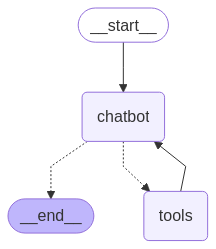

In [22]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "LPL\u8054\u8d5b\u51fb\u6740\u738b", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://news.qq.com/rain/a/20220818A05LLJ00", "title": "LPL\u5404\u8d5b\u5b63\u51fb\u6740\u738b\uff0c\u521a\u5b50\u7684\u8bb0\u5f55\u4fdd\u6301\u5230\u73b0\u5728-\u817e\u8baf\u65b0\u95fb - QQ News", "content": "LPL\u5404\u4e2a\u8d5b\u5b63\u7684\u51fb\u6740\u738b\uff0c\u5927\u591a\u6570\u90fd\u662f\u961f\u4f0d\u91cc\u7684AD\u6216\u8005\u4e2d\u5355\uff1a2013\u5e74\u6625\u5b63\u8d5b\u51fb\u6740\u738b\uff1aUZI\uff0c\u51fb\u6740\u6570\uff1a182\uff1b2013\u5e74\u590f\u5b63\u8d5b\u51fb\u6740\u738b\uff1aSan\uff0c\u51fb\u6740\u6570\uff1a148\uff1b2014\u5e74\u6625\u5b63\u8d5b\u51fb\u6740", "score": 0.7978881, "raw_content": null}, {"url": "https://m.hupu.com/bbs/628120595", "title": "\u5386\u5c4a\u5168\u7403\u603b\u51b3\u8d5b\u51fb\u6740\u738b\uff1aLPL\u9009\u624b - \u864e\u6251", "content": "\u864e\u625109\u670825\u65e5\u8bafLPL\u5b98\u65b9\u53d1\u5